In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay

In [ ]:
import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)


2.17.0
3.4.1


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

print("All imports were successful!")


All imports were successful!


In [ ]:
# Load images and labels
def load_images_and_labels(folder_path, image_size=(224, 224)):
    images = []
    labels = []
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        try:
            image = imread(file_path)
            if image is not None:
                image = resize(image, image_size, anti_aliasing=True)
                images.append(image)
                label = file.rsplit('_', 1)[0]
                labels.append(label)
        except Exception as e:
            print(f"Error loading {file}: {e}")
    return np.array(images), np.array(labels)


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Load dataset
folder_path =  '/content/drive/MyDrive/Colab Notebooks/Model/Data/Mendeley/classificacao_binaria/images'
images, labels = load_images_and_labels(folder_path)

img_train, img_test, lbl_train, lbl_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [ ]:

# Check the shape of images and labels
print("Shape of images:", images.shape)
print("Shape of labels:", labels.shape)

Shape of images: (3833, 224, 224, 3)
Shape of labels: (3833,)


# Data Preprocessing

In [ ]:
# Normalize the data
img_train = img_train / 255.0
img_test = img_test / 255.0

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
lbl_train_encoded = label_encoder.fit_transform(lbl_train)
lbl_test_encoded = label_encoder.transform(lbl_test)

num_classes = len(label_encoder.classes_)

# Convert labels to categorical
lbl_train_encoded = to_categorical(lbl_train_encoded, num_classes=num_classes)
lbl_test_encoded = to_categorical(lbl_test_encoded, num_classes=num_classes)

In [ ]:

# Define ImageDataGenerator with optimized augmentations
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate augmented data
def augment_data(X, y, datagen, target_size):
    augment_size = target_size - len(X)
    X_augmented, y_augmented = [], []

    for X_batch, y_batch in datagen.flow(X, y, batch_size=32):
        X_augmented.extend(X_batch[:augment_size - len(X_augmented)])
        y_augmented.extend(y_batch[:augment_size - len(y_augmented)])

        if len(X_augmented) >= augment_size:
            break

    return np.vstack((X, X_augmented)), np.hstack((y, y_augmented))

In [ ]:
# Target size for the augmented data
target_size = 3500

# Generate augmented data
img_augmented, lbl_augmented = augment_data(img_train, lbl_train, datagen, target_size)

# Combine original and augmented data
img_train_combined = np.vstack((img_train, img_augmented))
lbl_train_combined = np.hstack((lbl_train, lbl_augmented))

KeyboardInterrupt: 

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
lbl_train_encoded = label_encoder.fit_transform(lbl_train_combined)
lbl_test_encoded = label_encoder.transform(lbl_test)

num_classes = len(label_encoder.classes_)

# Convert labels to categorical
lbl_train_encoded = to_categorical(lbl_train_encoded, num_classes=num_classes)
lbl_test_encoded = to_categorical(lbl_test_encoded, num_classes=num_classes)

In [ ]:
# Data augmentation

datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)
batch_size = 32
# Create a TensorFlow dataset from the ImageDataGenerator
train_dataset = tf.data.Dataset.from_generator(
    lambda: datagen.flow(img_train, lbl_train_encoded, batch_size=32),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)
    )
).repeat()

# Create a TensorFlow dataset for validation
test_dataset = tf.data.Dataset.from_tensor_slices((img_test, lbl_test_encoded)).batch(batch_size)



In [ ]:
# Encode labels
label_encoder = LabelEncoder()
lbl_train_encoded = label_encoder.fit_transform(lbl_train)
lbl_test_encoded = label_encoder.transform(lbl_test)

num_classes = len(label_encoder.classes_)
num_classes
# Convert labels to categorical
lbl_train_encoded = to_categorical(lbl_train_encoded, num_classes=num_classes)
lbl_test_encoded = to_categorical(lbl_test_encoded, num_classes=num_classes)

# DCNN Model

In [ ]:
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(lbl_train), y=lbl_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Build the DCNN Model

dcnn_model = Sequential([
        Input(shape=(224, 224, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')
])


dcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=['accuracy'])
dcnn_model.summary()



In [ ]:
print("Combined images shape:", img_train.shape)

Combined images shape: (3066, 224, 224, 3)


In [ ]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((img_train, lbl_train_encoded))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(64).repeat()

val_dataset = tf.data.Dataset.from_tensor_slices((img_test, lbl_test_encoded))
val_dataset = val_dataset.batch(64)

# Calculate steps per epoch
steps_per_epoch = len(img_train) // 64
validation_steps = len(img_test) // 64

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)


In [ ]:
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(lbl_train), y=lbl_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

history = dcnn_model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=135,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/135
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.6024 - loss: 0.9986 - val_accuracy: 0.3153 - val_loss: 0.7005
Epoch 2/135
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.6972 - loss: 0.7577 - val_accuracy: 0.2698 - val_loss: 0.7156
Epoch 3/135
 2/47 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.7446 - loss: 0.6063

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.7512 - loss: 0.6485 - val_accuracy: 0.3153 - val_loss: 0.7261
Epoch 4/135
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.7689 - loss: 0.5974 - val_accuracy: 0.2698 - val_loss: 0.7477
Epoch 5/135
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.8022 - loss: 0.5118 - val_accuracy: 0.3153 - val_loss: 0.7537
Epoch 6/135
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.8061 - loss: 0.4885 - val_accuracy: 0.2698 - val_loss: 0.7544
Epoch 7/135
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.8097 - loss: 0.4560 - val_accuracy: 0.3153 - val_loss: 0.7520
Epoch 8/135
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.8201 - loss: 0.4144 - val_accuracy: 0.2698 - val_loss: 0.7430
Epoch 9/135
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.8536 - loss: 0.3638 - val_accuracy: 0.4503 - val_loss: 0.6836
Epoch 10/135
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.8576 - loss: 0.3311 - val_accuracy: 0.7619 - v

In [ ]:

# Training the DCNN model
batch_size = 32
epochs = 96
history = dcnn_model.fit(
    train_dataset,
    steps_per_epoch=len(img_train) // batch_size,
    epochs=epochs,
    validation_data=test_dataset,
    validation_steps=len(img_test) // batch_size,
    class_weight=class_weights_dict
)

# Evaluation

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = dcnn_model.evaluate(val_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8503 - loss: 0.3576
Test Loss: 0.32916945219039917
Test Accuracy: 0.8617992401123047


In [ ]:
print(lbl_test.shape)


(767,)


In [ ]:
# Predictions
lbl_pred = dcnn_model.predict(val_dataset)
lbl_pred_classes = np.argmax(lbl_pred, axis=1)
lbl_true_classes = np.argmax(lbl_test_encoded, axis=1)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [ ]:

# Generate a classification report
print("Classification Report DCNN:\n", classification_report(lbl_true_classes, lbl_pred_classes, target_names=label_encoder.classes_))


Classification Report DCNN:
                precision    recall  f1-score   support

   BenignCase       0.79      0.76      0.77       239
MalignantCase       0.89      0.91      0.90       528

     accuracy                           0.86       767
    macro avg       0.84      0.83      0.84       767
 weighted avg       0.86      0.86      0.86       767



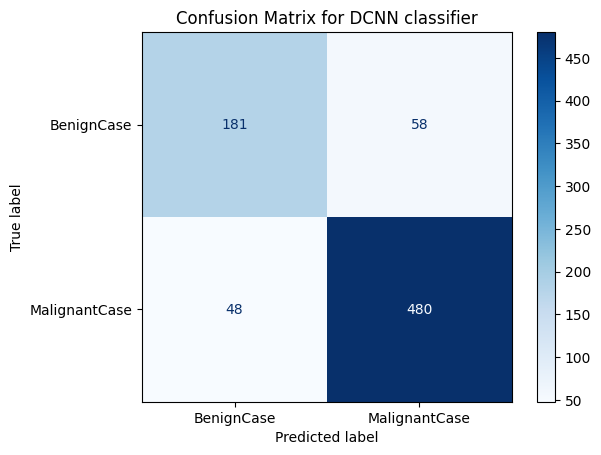

In [ ]:
# Compute confusion matrix
cm_Dcnn = confusion_matrix(lbl_true_classes, lbl_pred_classes)

# Display confusion matrix
disp_Dcnn = ConfusionMatrixDisplay(confusion_matrix=cm_Dcnn, display_labels=label_encoder.classes_)
disp_Dcnn.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for DCNN classifier')
plt.show()

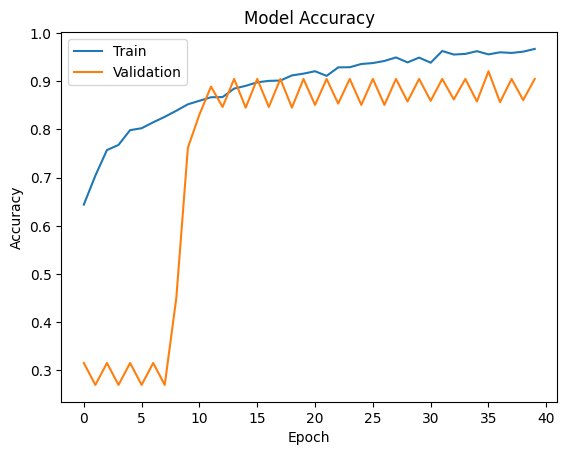

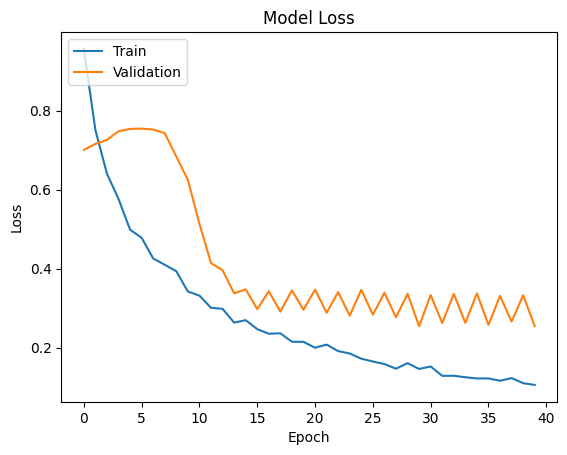

In [ ]:

# Assuming 'history' is the object returned by model.fit()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()